In [ ]:
from pathlib import Path
root = Path("figures")
root.mkdir(exist_ok=True)

# GOES X-ray Flux

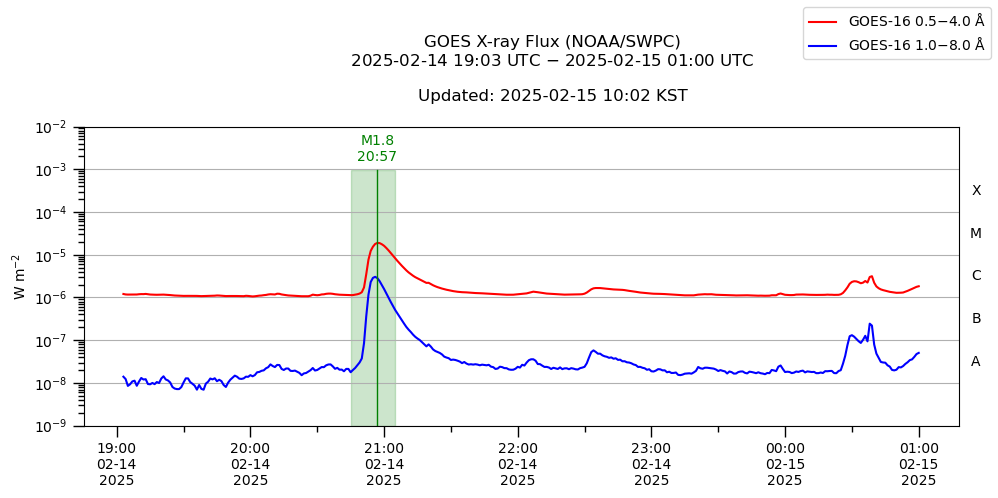

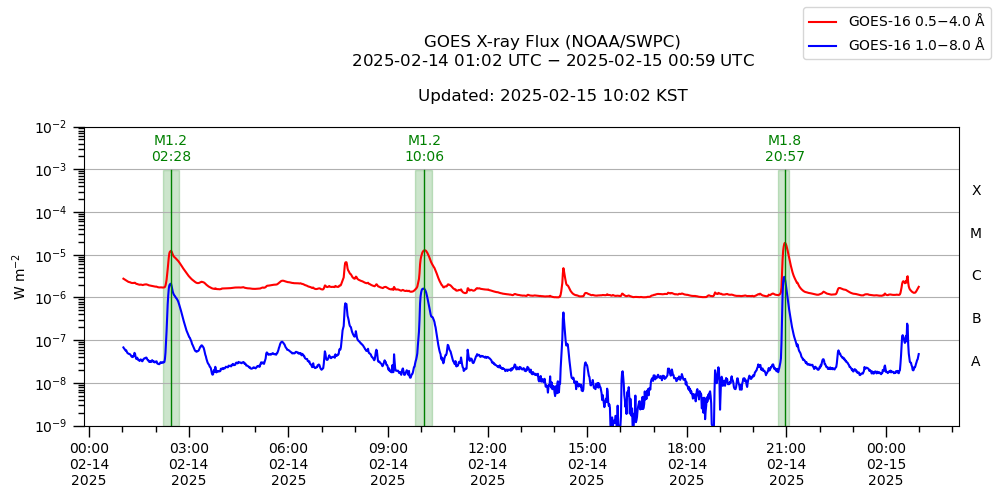

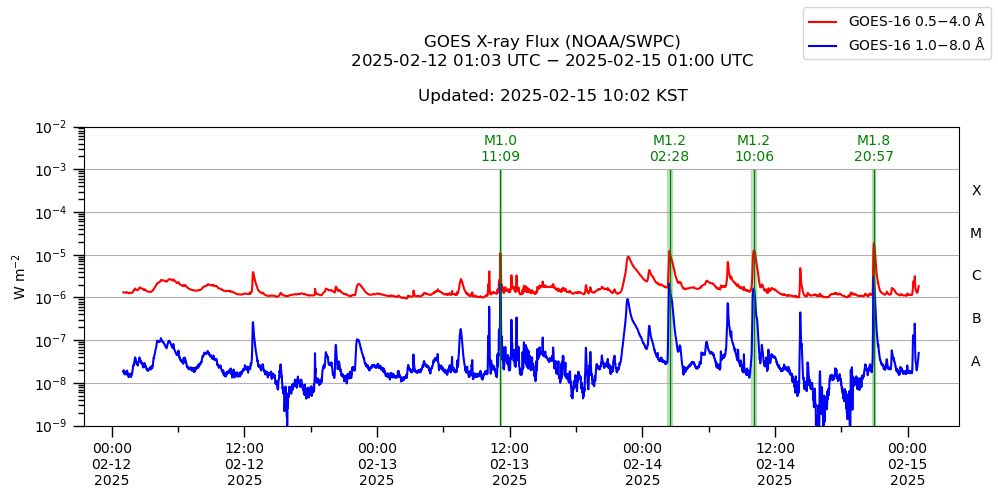

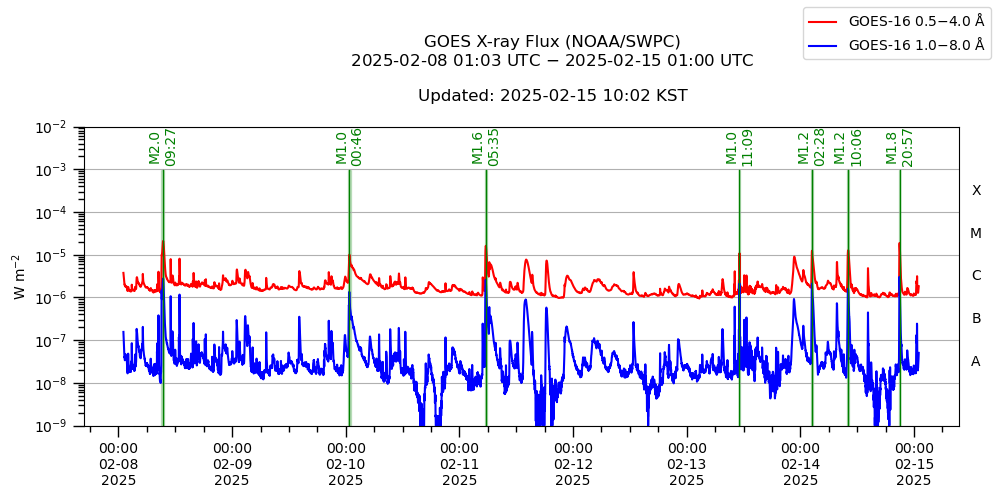

In [ ]:
import pandas as pd
from sunpy.time import parse_time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone, timedelta
import numpy as np

# data_type
data_type_list = ['xrays-6-hour', 'xrays-1-day', 'xrays-3-day', 'xrays-7-day']

for data_type in data_type_list:
    # get current time
    now = datetime.now(timezone.utc) + timedelta(hours=9)

    # get GOES X-ray data
    goes_json_data = pd.read_json(f"https://services.swpc.noaa.gov/json/goes/primary/{data_type}.json")
    goes_xrsa = goes_json_data[goes_json_data['energy'] == '0.05-0.4nm']
    goes_xrsb = goes_json_data[goes_json_data['energy'] == '0.1-0.8nm']

    # get satellite number
    satellite = str(goes_json_data['satellite'].unique()[0])

    # get time range
    time_array = parse_time(goes_xrsa['time_tag']).datetime
    first_time = time_array[0]
    last_time = time_array[-1]

    # create figure and plot
    fig, ax = plt.subplots(figsize=(10, 5))

    # plot GOES X-ray flux
    ax.plot(parse_time(goes_xrsb['time_tag']).datetime, goes_xrsb['flux'].values,
            label=f"GOES-{satellite} " +  r"0.5$-$4.0 $\mathrm{\AA}$", color='red')
    ax.plot(parse_time(goes_xrsa['time_tag']).datetime, goes_xrsa['flux'].values, 
            label=f"GOES-{satellite} " +  r"1.0$-$8.0 $\mathrm{\AA}$", color='blue')

    # set y-axis scale and limit
    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e-2)
    ax.set_ylabel("W m$^{-2}$")

    # set grid and ticks
    ax.yaxis.grid(True, "major")
    ax.xaxis.grid(False, "major")
    ax.tick_params(axis='x', which='minor', length=4, width=1, color='black')
    ax.tick_params(axis='x', which='major', length=8, width=1, color='black')
    ax.tick_params(axis='y', which='minor', length=4, width=1, color='black')
    ax.tick_params(axis='y', which='major', length=8, width=1, color='black')

    # set y-axis labels (flare class)
    labels = ['A', 'B', 'C', 'M', 'X']
    centers = np.logspace(-7.6, -3.6, len(labels))
    for value, label in zip(centers, labels):
        ax.text(1.02, value, label, transform=ax.get_yaxis_transform(), horizontalalignment='center')

    # x-axis tick time format
    if data_type == 'xrays-6-hour':
        plt.xticks(rotation=0)
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m-%d\n%Y'))
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0, 30]))
    if data_type == 'xrays-1-day':
        plt.xticks(rotation=0)
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m-%d\n%Y'))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
    if data_type == 'xrays-3-day':
        plt.xticks(rotation=0)
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m-%d\n%Y'))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 6)))
    if data_type == 'xrays-7-day':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%m-%d\n%Y'))
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 6)))

    # plot flare events
    goes_xray_flare_week = pd.read_json("https://services.swpc.noaa.gov/json/goes/primary/xray-flares-7-day.json")
    goes_xray_flare_week = goes_xray_flare_week[goes_xray_flare_week['max_class'].str.startswith('M')]
    goes_xray_flare_week['max_time_datetime'] = parse_time(goes_xray_flare_week['max_time']).datetime
    goes_xray_flare_week = goes_xray_flare_week[goes_xray_flare_week['max_time_datetime'] >= first_time]
    for i, s in goes_xray_flare_week.iterrows():
        ax.axvline(s['max_time'], color='green', linestyle='-', linewidth=1, ymax=0.855)
        ax.axvspan(s['begin_time'], s['end_time'], color='green', alpha=0.2, ymax=0.855)
        if data_type == 'xrays-6-hour':
            class_text = f"{s['max_class']}\n{s['max_time'].strftime('%H:%M')}"
            ax.text(s['max_time'], 1.3e-3, class_text, color='green', rotation=0, verticalalignment='bottom', horizontalalignment='center')
        if data_type == 'xrays-1-day':
            class_text = f"{s['max_class']}\n{s['max_time'].strftime('%H:%M')}"
            ax.text(s['max_time'], 1.3e-3, class_text, color='green', rotation=0, verticalalignment='bottom', horizontalalignment='center')
        if data_type == 'xrays-3-day':
            class_text = f"{s['max_class']}\n{s['max_time'].strftime('%H:%M')}"
            ax.text(s['max_time'], 1.3e-3, class_text, color='green', rotation=0, verticalalignment='bottom', horizontalalignment='center')
        if data_type == 'xrays-7-day':
            class_text = f"{s['max_class']}\n{s['max_time'].strftime('%H:%M')}"
            ax.text(s['max_time'], 1.22e-3, class_text, color='green', rotation=90, verticalalignment='bottom', horizontalalignment='center')

    # set legend and title
    fig.legend(loc='upper right')
    plt.title(f"""
            GOES X-ray Flux (NOAA/SWPC)
            {first_time.strftime("%Y-%m-%d %H:%M")} UTC $-$ {last_time.strftime("%Y-%m-%d %H:%M")} UTC
            
            Updated: {now.strftime("%Y-%m-%d %H:%M")} KST
            """)
    plt.tight_layout()
    fig.savefig(root / f"goes_{data_type}.png", dpi=300)
    plt.show()